<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/ColorConvolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle

!pip3 install histomicstk
import histomicstk as htk
#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


################################################################################
# Read Data from google drive
################################################################################
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

###                     MAIN DIRECTORY NAMES
gdir = '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#
feature_folder = os.path.join(gdir,'FEATURE_EXTRACTION')
original_image_folder = os.path.join(feature_folder,'tiles_rois','original')

tiles_dir = os.path.join(feature_folder,'tiles_rois','normalized')
tile_melanomas_dir = os.path.join(gdir,feature_folder,'tile_melanomas_examples')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')
mask_dir = os.path.join(gdir,'masks')

preprocess_dir = os.path.join(gdir,'TILE_PREPROCESSING')
original_output_dir = os.path.join(gdir,'TILE_PREPROCESSING','ORIGINAL_TO_HE')




#pickle file used to store full image sets, which take more than a minute to run
pickle_file = os.path.join(preprocess_dir,'PICKLE_FILE.pck')
he_pickle_file = os.path.join(preprocess_dir,'PICKLE_FILE_HE_IMAGES.pck')

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 4.7MB 15.3MB/s 
     |████████████████████████████████| 194kB 43.4MB/s 
     |████████████████████████████████| 133kB 48.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 317kB 44.1MB/s 
  Created wheel for large-image-source-tiff: filename=large_image_source_tiff-1.0.2-cp36-none-any.whl size=15906 sha256=d28eef4cbfec75a4ccc7ef030de5c5366f333eb6056f5a6e9fe02fa36c6fab88
  Stored in directory: /root/.cache/pip/wheels/00/68/16/f21f383e083fb0b6d060fa078802cae75460265ee73a13ebd8
  Created wheel for girder-client: filename=girder_client-3.0.8-cp36-none-any.whl size=21335 sha256=2a18ca7a24fec235e2e7a702d0b63d886365e5947f02a52581dfa2ee31eb3f2b
  Stored in directory: /root/.cache/pip/wheels/2f/06/e3/b46e96337859813efb1b07d23de91a42740b89e69da6f1ddf0
  Created wheel for large-image-source-openslide:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Now at image #  0
Now at image #  100
Now at image #  200
Now at image #  300
Now at image #  400
Now at image #  500
Now at image #  600
Now at image #  700
Now at image #  800
Now at image #  900


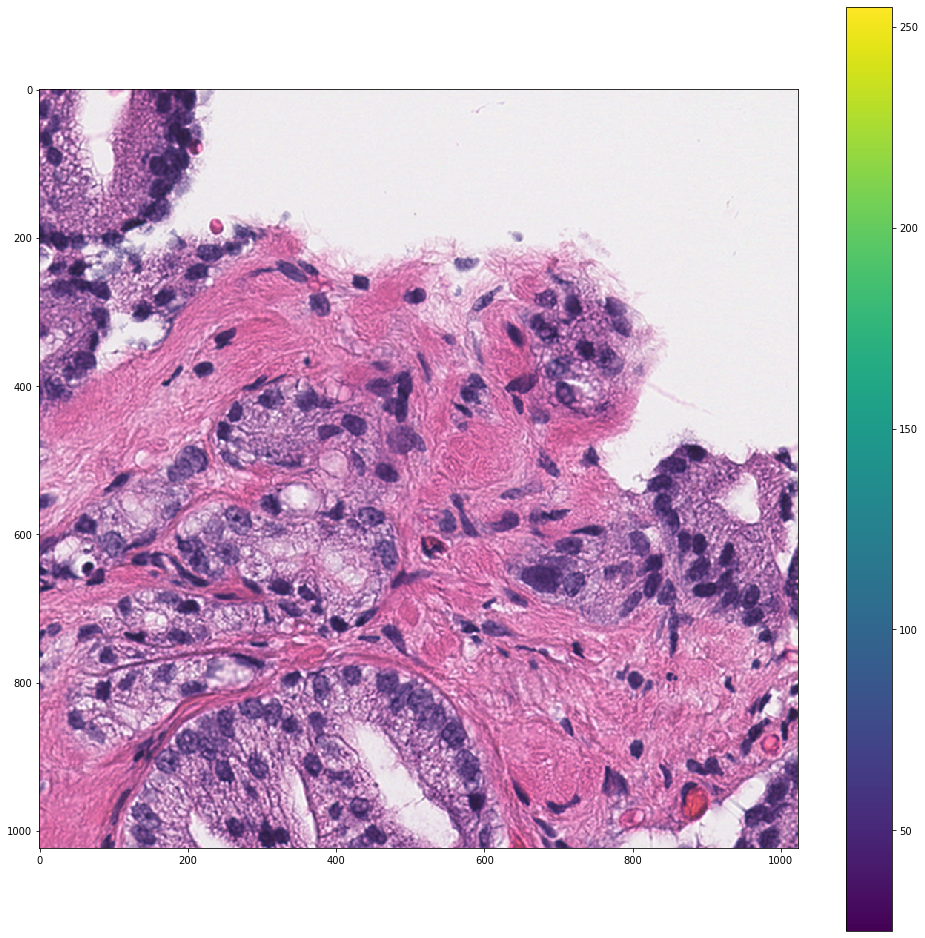

In [2]:
'''
Get image files and load them into memory
'''


#get listing of image files in directory
image_files = os.listdir(original_image_folder)

image_names =[]
#store filenames without extension for output purposes later
for filename in image_files:
    root_ext = os.path.splitext(filename) #will return two parts, name and ext
    image_names.append(root_ext[0])


#resizing parameters for raw to final 
NX = 1024
NY = NX

#open the images
image_data = {}
for fcounter,filename in enumerate(image_files):
    full_filename = os.path.join(original_image_folder,filename)
    #root_ext = os.path.splitext(filename)
    #tile_file = root_ext[0] + '.png'
    #    tile_roi_file = os.path.join(tiles_dir, tile_file)

    if ((fcounter % 100) == 0):
        print('Now at image # ', fcounter)
    
    image_data[fcounter] = Image.open(full_filename)
    image_data[fcounter] = image_data[fcounter].resize((1024, 1024), Image.ANTIALIAS)
    

#review sample image
plt.figure(figsize=(17, 17))
plt.imshow(image_data[5])
plt.colorbar()
plt.show()

In [3]:
'''
Save intermediate data to a pickle file. This should save some recomputing time
'''

print('pickle file is ', pickle_file)
with open(pickle_file, 'wb') as f:
    pickle.dump(image_data, f)

print('Saved full image set to pickle file')

pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE.pck
Saved full image set to pickle file


In [4]:
'''
Perform histomicsTK prep
'''

#defaults for HE staining from HTK site
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

deconvolved_image_h={}
deconvolved_image_e={}
for ii,fcounter in enumerate(image_data):

    if ((fcounter % 100) == 0):
        print('Now Deconvolving image # ', fcounter)
    imInput = np.array(image_data[fcounter]) #convert to NP array format first
    # perform standard color deconvolution
    imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

    #store this output set in H and E dictionaries
    deconvolved_image_h[fcounter] = imDeconvolved.Stains[:,:,0]
    deconvolved_image_e[fcounter] = imDeconvolved.Stains[:,:,1]

print('shape of imDeconvolved is ', np.shape(imDeconvolved))


stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}
Now Deconvolving image #  0
Now Deconvolving image #  100
Now Deconvolving image #  200
Now Deconvolving image #  300
Now Deconvolving image #  400
Now Deconvolving image #  500
Now Deconvolving image #  600
Now Deconvolving image #  700
Now Deconvolving image #  800
Now Deconvolving image #  900
shape of imDeconvolved is  (3,)


In [7]:
for ii in range(0,len(deconvolved_image_h)):

    current_image_name = image_names[ii]

    plt.figure()
    plt.imshow(deconvolved_image_h[ii],cmap = 'gray')
    htitle = 'Hematoxylin_' + current_image_name + '_File#_'+ str(ii)
    hfile = htitle + '.png'
    hfile = os.path.join(original_output_dir,hfile);
    plt.colorbar()
    plt.title(htitle)
    plt.savefig(hfile, format='png',dpi=300, bbox_inches='tight')

    plt.figure()
    plt.imshow(deconvolved_image_e[ii],cmap = 'gray')
    etitle = 'Eosin_' + current_image_name + '_File#_'+ str(ii)
    efile = etitle + '.png'
    efile = os.path.join(original_output_dir,efile);
    plt.colorbar()
    plt.title(etitle)
    plt.savefig(efile, format='png',dpi=300, bbox_inches='tight')


    if ((ii % 100) == 0):
        print('Now Writing Deconvolved Image to GDRIVE:# ', ii)


    plt.close('all')


Now Writing Deconvolved Image to GDRIVE:#  0
Now Writing Deconvolved Image to GDRIVE:#  100
Now Writing Deconvolved Image to GDRIVE:#  200
Now Writing Deconvolved Image to GDRIVE:#  300
Now Writing Deconvolved Image to GDRIVE:#  400
Now Writing Deconvolved Image to GDRIVE:#  500
Now Writing Deconvolved Image to GDRIVE:#  600
Now Writing Deconvolved Image to GDRIVE:#  700
Now Writing Deconvolved Image to GDRIVE:#  800
Now Writing Deconvolved Image to GDRIVE:#  900


In [6]:
'''
Save HE data to a pickle file. This should save some recomputing time and
won't have all the matplotlib overlaying data
'''
#packaging up the two H & E datasets for pickle storage

he_data = [deconvolved_image_h,deconvolved_image_e, image_names]
print('pickle file is ', he_pickle_file)
with open(he_pickle_file, 'wb') as f:
    pickle.dump(he_data, f)

print('Saved full HE image set to pickle file')

pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE_HE_IMAGES.pck
Saved full HE image set to pickle file


In [0]:
'''
Statistics on h and e images
'''


#
# GLCM
#
from skimage.feature import greycomatrix, greycoprops


xs = []
ys = []

for fkey in deconvolved_image_h:
    glcm = greycomatrix(deconvolved_image_h[fkey],
                        distances=[25],
                        angles=[0],
                        levels=256,
                        symmetric=True,
                        normed=True)
    xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(greycoprops(glcm, 'correlation')[0, 0])



xs_e = []
ys_e = []

for fkey in deconvolved_image_e:
    glcm = greycomatrix(deconvolved_image_e[fkey],
                        distances=[25],
                        angles=[0],
                        levels=256,
                        symmetric=True,
                        normed=True)
    xs_e.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys_e.append(greycoprops(glcm, 'correlation')[0, 0])





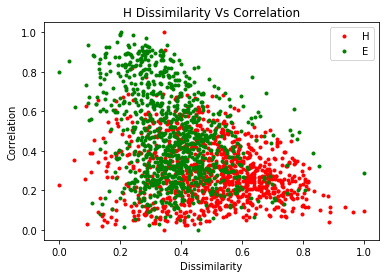

In [40]:
ymin = np.min(ys)
ymax = np.max(ys)
ynew=[]
for ii in ys:
    ynew.append( (ii - ymin)/(ymax - ymin)) 

xmin = np.min(xs)
xmax = np.max(xs)
xnew=[]
for ii in xs:
    xnew.append( (ii - xmin)/(xmax - xmin)) 


plt.figure()
plt.plot(xnew,ynew, 'r.')
plt.xlabel('Dissimilarity')
plt.ylabel('Correlation')
plt.title('H&E Dissimilarity Vs Correlation')


#plotting E and H together requires the dissimilarity be normalized to 1

ymin = np.min(ys_e)
ymax = np.max(ys_e)
ynew=[]
for ii in ys_e:
    ynew.append( (ii - ymin)/(ymax - ymin)) 

xmin = np.min(xs_e)
xmax = np.max(xs_e)
xnew=[]
for ii in xs_e:
    xnew.append( (ii - xmin)/(xmax - xmin)) 

#plt.figure()
plt.plot(xnew,ynew, 'g.')
plt.legend(('H','E'))
#plt.xlabel('Dissimilarity')
#plt.ylabel('Correlation')
#plt.title('E Dissimilarity Vs Correlation')
